# Reservoir Computing
### EPFL - Advanced Computing course 2017

_Francesco Cremonesi_

This is the code accompanying my project report. This code uses [pyNEST](http://www.nest-simulator.org/) to instantiate a simulation of leaky integrate-and-fire neurons, which is used as a reservoir for learning a text generation task.

In [1]:
import nest
import time
import numpy as np
from numpy import exp
import os
import random
import h5py
import json
import matplotlib.pyplot as plt
% matplotlib inline

#### Setting up of NEST

Set the number of threads to speed up simulations (caveat: setting this to the maximum number of threads is not always the best option, since NEST is mainly a memory-bound code).

Moreover, I have tried without success to initialize all the random seeds, to make sure that NEST's behaviour is reproducible. After some trial and error, I was forced to give up.

In [2]:
nest.ResetKernel()
nest.SetKernelStatus({"local_num_threads": 8})
nest.set_verbosity('M_FATAL')

In [3]:
msd = 123456
N_vp = nest.GetKernelStatus(['total_num_virtual_procs'])[0]

pyrngs = [np.random.RandomState(s) for s in range(msd, msd+N_vp)]

nest.SetKernelStatus({'grng_seed' : msd+N_vp})
nest.SetKernelStatus({'rng_seeds' : range(msd+N_vp+1, msd+2*N_vp+1)})

#### Reading inputs

In [4]:
inputf = h5py.File('../../lua-torch/dante/data/dante.h5','r')
input_seq = inputf['train']

In [5]:
inputjson = open('../../lua-torch/dante/data/dante.json','r')
jsondata = json.load( inputjson )
ntokens = max( [ int(x) for x in jsondata['idx_to_token'].keys()] )
print 'there are', ntokens, 'tokens'

there are 77 tokens


## Setting up the Reservoir

### Simulation configuration

#### Number of neurons and parameters

In [6]:
dt = 0.1    # the resolution in ms
delay = 0.3    # synaptic delay in ms

N_neurons = 5000

N_rec = int(0.4*N_neurons)

In [7]:
C_tot = int(0.1*N_neurons)

tauMem = 20.0  # time constant of membrane potential in ms
theta = 20.0  # membrane threshold potential in mV
J = 3.0   # postsynaptic amplitude in mV
g = 5.0
tau_syn = 0.6
neuron_params = {"C_m": 1.0,
                 "tau_m": tauMem,
                 "t_ref": 0.4,
                 "E_L": 0.0,
                 "V_reset": 0.0,
                 "V_m": 0.0,
                 "V_th": theta,
                 "tau_syn_ex": tau_syn,
                 "tau_syn_in": tau_syn}

#### Stimulation times 

In [8]:
single_input_stimul_time = 5.0
single_input_quiet_time = 15.0
single_input_sim_time = single_input_stimul_time + single_input_quiet_time

# there are 661393 characters in the text
n_char_input = 5000.0
max_simtime = n_char_input*single_input_sim_time

print ' your chosen max_simtime:', max_simtime, ' ms'
print 'corresponds to ', \
      int(max_simtime/single_input_sim_time), \
    'characters analyzed in the text'


 your chosen max_simtime: 100000.0  ms
corresponds to  5000 characters analyzed in the text


In [9]:
nest.SetKernelStatus({"resolution": dt, "print_time": True,
                      "overwrite_files": True})

### Building the network

#### Create excitatory and inhibitory neurons

In [10]:
nest.SetDefaults("iaf_psc_exp", neuron_params)

nodes_ex = nest.Create("iaf_psc_exp",int(0.8*N_neurons))
nodes_in = nest.Create("iaf_psc_exp",int(0.2*N_neurons))
nodes = nodes_ex + nodes_in

#### Create inputs

An input will inject a random sequence of external spikes into a subset of the neurons. Different inputs correspond to different tokens in the input sequence.

In [11]:
inputs = []
for i in range(ntokens):
    inputs.append(nest.Create("poisson_generator"))
    nest.SetStatus( inputs[ i ], {"rate": 0.0} )

In [12]:
nest.CopyModel("static_synapse", "excitatory", {"delay": delay})
nest.CopyModel("static_synapse", "inhibitory", {"delay": delay})

#### Connect the inputs

1. randomly select a subset of neurons per token. The number of neurons associated with each token is given by the variable `N_nodes_per_input`;
2. connect each input to the corresponding neurons;
3. initialize the spiking rate of each input to 0.0

In [13]:
N_nodes_per_input = 4
index_of_nodes_that_receive_input = np.random.choice(N_neurons, N_nodes_per_input*ntokens, replace=False)
nodes_that_receive_input = [x for i,x in enumerate(nodes) if i in index_of_nodes_that_receive_input]

for i in range(ntokens):
    nest.Connect( inputs[i], 
                 nodes_that_receive_input[N_nodes_per_input*i:N_nodes_per_input*(i+1)], 
                 syn_spec="excitatory")
    nest.SetStatus( inputs[i], {"rate": 0.0} )

#### Setup the readouts

First, create an instance of a spike detector.

In [14]:
spikes = nest.Create("spike_detector")

nest.SetStatus(spikes, [{"label": "readout",
                          "withtime": True,
                          "withgid": True,
                          "to_memory": True,
                          "to_file": False}])

#### Connect the readouts

select a subset of `N_rec` neurons that will act as readout neurons. Connect each one to the spike detector.

In [15]:
index_of_nodes_that_provide_output = np.random.choice(N_neurons, N_rec, replace=False)
nodes_that_provide_output = [x for i,x in enumerate(nodes) if i in index_of_nodes_that_provide_output]
nest.Connect( nodes_that_provide_output, spikes, syn_spec="excitatory")

#### Define the connectivity

I choose to connect the neurons with a random weight drawn from a normal distribution. As is customary for a balanced network, the inhibitory weights are stronger than the excitatory ones, but there are less inhibitory connections in the network.

In [16]:
syn_params_ex = {"model": "excitatory", "weight": {'distribution': 'normal', 'mu': J, 'sigma':1.0}}
syn_params_in = {"model": "inhibitory", "weight": {'distribution': 'normal', 'mu': -g*J, 'sigma':1.0}}

#### Create the connections between neurons

Connections obey the following rules:
- each neuron receives exactly `indegree` connections;
- excitatory neurons only make excitatory __outgoing__ connections, and vice versa for inhibitory.


In [17]:
conn_params_ex = {'rule': 'fixed_indegree', 'indegree': int(0.8*C_tot)}
nest.Connect(nodes_ex, nodes, conn_params_ex, syn_params_ex)

conn_params_in = {'rule': 'fixed_indegree', 'indegree': int(0.2*C_tot)}
nest.Connect(nodes_in, nodes, conn_params_in, syn_params_in)

### Simulate!

The basic simulation loop is the following:
1. get the corresponding character in the input sequence, whose token value is `input_idx`;
2. activate the corresponding input with a frequency of 100Hz, for a period of time of duration `single_input_stimul_time`;
3. silnce the input, and let the network evolve for a period of duration `single_input_quiet_time`;
4. if maximum time has not been reached, repeat from 1.

In [18]:
sequence_metadata = list()
simtime = 0.0

for j, input_idx in enumerate(input_seq):
    sequence_metadata.append( ( j*single_input_sim_time, (j+1)*single_input_sim_time, input_idx) )
    
    nest.SetStatus( inputs[ input_idx - 1 ], {"rate": 100000.0} )
    nest.Simulate(single_input_stimul_time)
    simtime += single_input_stimul_time

    nest.SetStatus( inputs[ input_idx - 1 ], {"rate": 0.0} )   
    nest.Simulate(single_input_quiet_time)
    simtime += single_input_quiet_time
    
    if simtime >= max_simtime:
        break

#### Retrieve all the spikes from the detector

And sort them for convenience

In [19]:
def get_all_spikes(detector):
    dSD = nest.GetStatus(detector,keys="events")[0]
    spike_times = np.array(dSD["senders"])
    spike_times = np.c_[ spike_times, np.array(dSD["times"]) ]
    spike_times =spike_times[ spike_times[:,1].argsort() ]
    return spike_times

In [20]:
spike_times = get_all_spikes(spikes)

print 'Counted ', spike_times.shape[0], ' spikes'

Counted  2982979  spikes


In [21]:
events = nest.GetStatus(spikes, "n_events")[0]

rate = events / simtime * 1000.0 / N_rec

num_synapses = (nest.GetDefaults("excitatory")["num_connections"])

print("Brunel network simulation (Python)")
print("Number of neurons : {0}".format(N_neurons))
print("Number of synapses: {0}".format(num_synapses))
print("Firing rate       : %.2f Hz" % rate)

Brunel network simulation (Python)
Number of neurons : 5000
Number of synapses: 2002308
Firing rate       : 14.91 Hz


#### Two different ways of generating a raster plot

In [22]:
#import nest.raster_plot
#nest.raster_plot.from_device(spikes, hist=True)
#print simtime

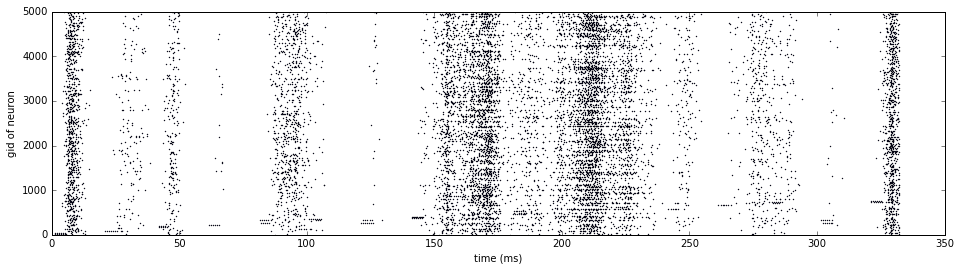

In [23]:
plt.figure(figsize=(16,4))
plt.plot(spike_times[:10000,1], spike_times[:10000,0], 'ob', markersize=0.9)
#plt.xlim((0,simtime))
#plt.xlim((0,300))
plt.xlabel('time (ms)')
plt.ylabel('gid of neuron')
plt.savefig('raster-smallStimTimes.pdf')

## Train the readouts with Ridge Regression

In the second phase, we gather all the spike outputs, parse them in a meaningful way and train the readout weights using ridge regression.

I define a `line_offset` because the network's initial conditions might have an effect that I wish to ignore. Basically `line_offset` is equal to the number of input character I wish to ignore at the beginning.

In [24]:
from numpy.linalg import inv

nseq = len(sequence_metadata)
nreadout = N_rec
line_offset = 10
time_window = 7.0*single_input_sim_time

print 'Counted ', nseq, ' sequences'

Counted  5000  sequences


#### Design and Output matrix

$X $ is going to be the design matrix. Actually, 

$X = [\tilde{X}; U; 1] $ 

where: 
- $\tilde{X}_{ij} $ is the firing frequency of the $i^{th} $ readout neuron, during the $j^{th} $ time window;
- $U_{ij} $ is 1 if the $i^{th} $ token was the last to be presented during the $j^{th} $ time window, 0 otherwise.

On the other hand, $Y_{ij} $ is 1 if the $i^{th} $ token is the first to be presented __after__ $j^{th} $ time window, 0 otherwise.

In [25]:
X = np.zeros( shape=(nreadout + ntokens + 1, nseq-line_offset-1) )
Y = np.zeros( shape=(ntokens, nseq-line_offset-1) )

To fill $X$ and $Y$, I am going to iterate over the output spikes, computing a firing frequency (in kHz) and insert the value in the corresponding matrix element.

In [26]:
def get_x(spike_times, unique_gids, endtime, time_window):
    gids = spike_times[ np.logical_and( 
            spike_times[:,1] <= endtime, 
            spike_times[:,1] >= endtime - time_window), 0 ]

    x, _ = np.histogram( gids, bins=unique_gids) 
    x = np.lib.pad(x,(0,nreadout - len(unique_gids) +1 ), 'constant', constant_values=(0,0) )
    x = x*1.0/time_window
    return x

_CAUTION_ the following cell may be very time consuming.

In [27]:
unique_gids = np.sort( np.unique( spike_times[ :, 0] ) )

tt = (line_offset+1)*single_input_sim_time

for i in range(nseq-line_offset-1):
    if i % int(0.1*(nseq-line_offset-1)) == 0:
        print float(i)/(nseq-line_offset-1)*100.0, '% complete'
    xx = get_x(spike_times, unique_gids, tt, time_window)
    u_idx = sequence_metadata[i+line_offset][2]
    uu = np.zeros(shape=(ntokens,))
    uu[u_idx - 1] = 1.0
    X[:,i] = np.r_[xx,uu, 1.0]
    metadata = sequence_metadata[i+line_offset+1]
    token_to_predict = metadata[2]
    Y[token_to_predict-1, i] = 1
    tt += single_input_sim_time
    
orig_X = np.array(X, copy=True)

0.0 % complete
9.98196031269 % complete
19.9639206254 % complete
29.9458809381 % complete
39.9278412508 % complete
49.9098015634 % complete
59.8917618761 % complete
69.8737221888 % complete
79.8556825015 % complete
89.8376428142 % complete
99.8196031269 % complete


The following is a utility cell to test out different training scenarios:

In [28]:
# 1. standard reservoir training scenario
X = np.array(orig_X, copy=True)

# 2. no reservoir
#X = np.array(orig_X, copy=True)
#X[nreadout:,:] = 0.

# 3. no input concatenation
#X = np.array(orig_X, copy=True)
#X[:nreadout,:] = 0.

# 4. no constant term only
#X = np.array(orig_X, copy=True)
#X[:-1,:] = 0.

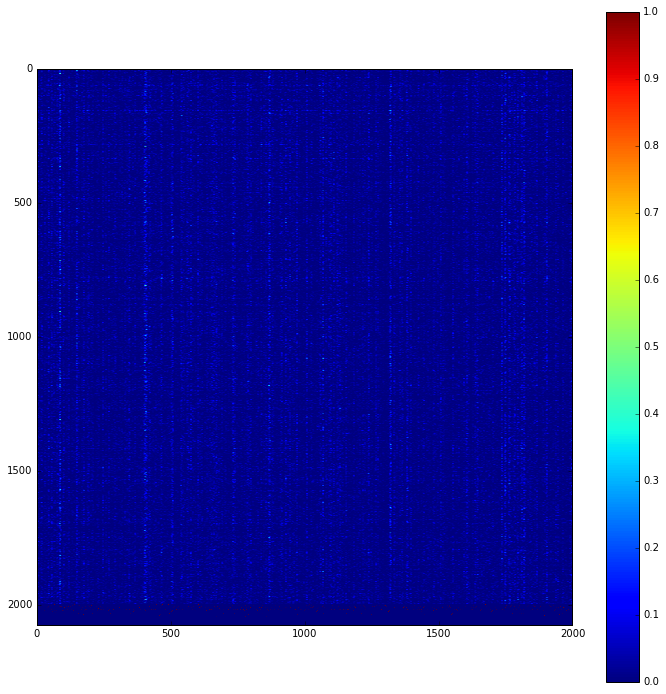

In [29]:
plt.figure(figsize=(12,12))
plt.imshow(X[:,:2000])
plt.colorbar()
#plt.savefig('X-noU.pdf')

In [172]:
print 'Computing W'

beta = 1.0

grahm = np.dot(X, X.T)
grahm += beta*np.eye( nreadout + ntokens + 1 )

W = Y.dot( X.T.dot( inv( grahm ) ) )

print W.shape

Computing W
(77, 2078)


In [ ]:
plt.figure(figsize=(12,12))
grahm = np.dot(X, X.T)
plt.imshow(grahm)
plt.colorbar()

In [ ]:
#grahm += beta*np.eye( nreadout )
#plt.figure(figsize=(12,12))
#plt.imshow(grahm)
#plt.colorbar()

In [ ]:
#tmp = inv( grahm ) 
#plt.figure(figsize=(12,12))
#plt.imshow(tmp)
#plt.colorbar()

In [ ]:
#tmp = X.T.dot( inv( grahm ) ) 
#plt.figure(figsize=(12,12))
#plt.imshow(tmp)
#plt.colorbar()

In [ ]:
plt.figure(figsize=(24,12))
plt.imshow(Y[:,:400], interpolation='none')
plt.colorbar()

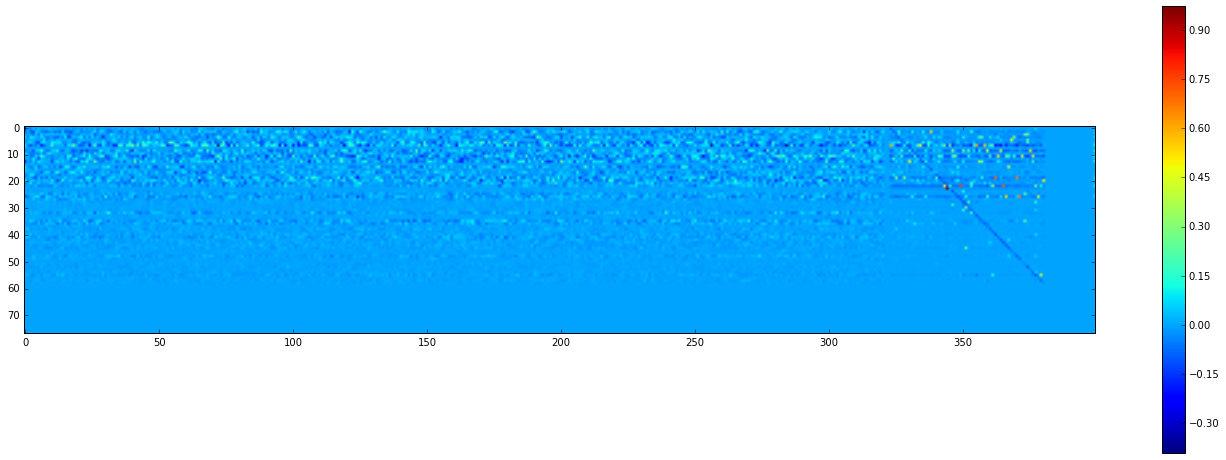

In [173]:
plt.figure(figsize=(24,8))
plt.imshow(W[:,-400:])
plt.colorbar()
#plt.savefig('W-smallB.pdf')

In [186]:
print 'Input a sequence to start sampling'
sample_seq = raw_input()

if not sample_seq:
    assert False

sample_seq = [ jsondata['token_to_idx'][x] for x in sample_seq ]

Input a sequence to start sampling
"Marvel thou not," she said to me, "because


In [187]:
for i in range(ntokens):
    nest.SetStatus( inputs[i], {"rate": 0.0} )
    
resting_time = 200.0
nest.Simulate(resting_time)

for j, input_idx in enumerate(sample_seq):
    nest.SetStatus( inputs[ input_idx - 1 ], {"rate": 100000.0} )
    nest.Simulate(single_input_stimul_time)
    simtime += single_input_stimul_time

    nest.SetStatus( inputs[ input_idx - 1 ], {"rate": 0.0} )   
    nest.Simulate(single_input_quiet_time)
    simtime += single_input_quiet_time

nest.SetStatus( inputs[ sample_seq[-1] -1 ], {"rate": 0.0} )

In [188]:
spike_times = get_all_spikes(spikes)

print 'Counted ', spike_times.shape[0], ' spikes'

Counted  4736721  spikes


In [189]:
import sys
for i in range(ntokens):
    nest.SetStatus( inputs[i], {"rate": 0.0} )

len_sample = 200

old_input_idx = sample_seq[-1]

for t in range(len_sample):
    # predict next character
    spike_times = get_all_spikes(spikes)
    xx = get_x( spike_times, unique_gids, simtime, time_window)
    uu = np.zeros(shape=(ntokens,))
    uu[old_input_idx - 1] = 1.0
    x = np.r_[xx,uu,1.0]
    c_idx = np.argmax( np.dot( W, x ) )
    predicted_char = jsondata['idx_to_token'][ str( c_idx + 1) ]
#    print '=============> ', repr( predicted_char )
    sys.stdout.write(predicted_char)
    old_input_idx = c_idx + 1
    # feedback
    input_val = int( jsondata['token_to_idx'][predicted_char] )
    nest.SetStatus( inputs[ input_val - 1 ], {"rate": 100000.0} )

    # simulate
    nest.Simulate(single_input_stimul_time)
    simtime += single_input_stimul_time
    
    nest.SetStatus( inputs[ input_val - 1 ], {"rate": 0.0} )

    # simulate
    nest.Simulate(single_input_quiet_time)
    simtime += single_input_quiet_time


  oure the the the me s as e me me the the      

KeyboardInterrupt: 